### Processing of both AUs and Compound Emotions

if we were to create a pipeline for both AUs and Compound Emotions, we would need to use this processing since some images are annotated with null values for the AU labels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
working_dir = "../../../../Documents/FER-CE-Vision-LLM/data/"
compound_df = pd.read_csv(working_dir+"compound_df_clean.csv")
au_df =  pd.read_csv(working_dir+"au_features_clean.csv")
print(au_df.shape)

(4549, 30)


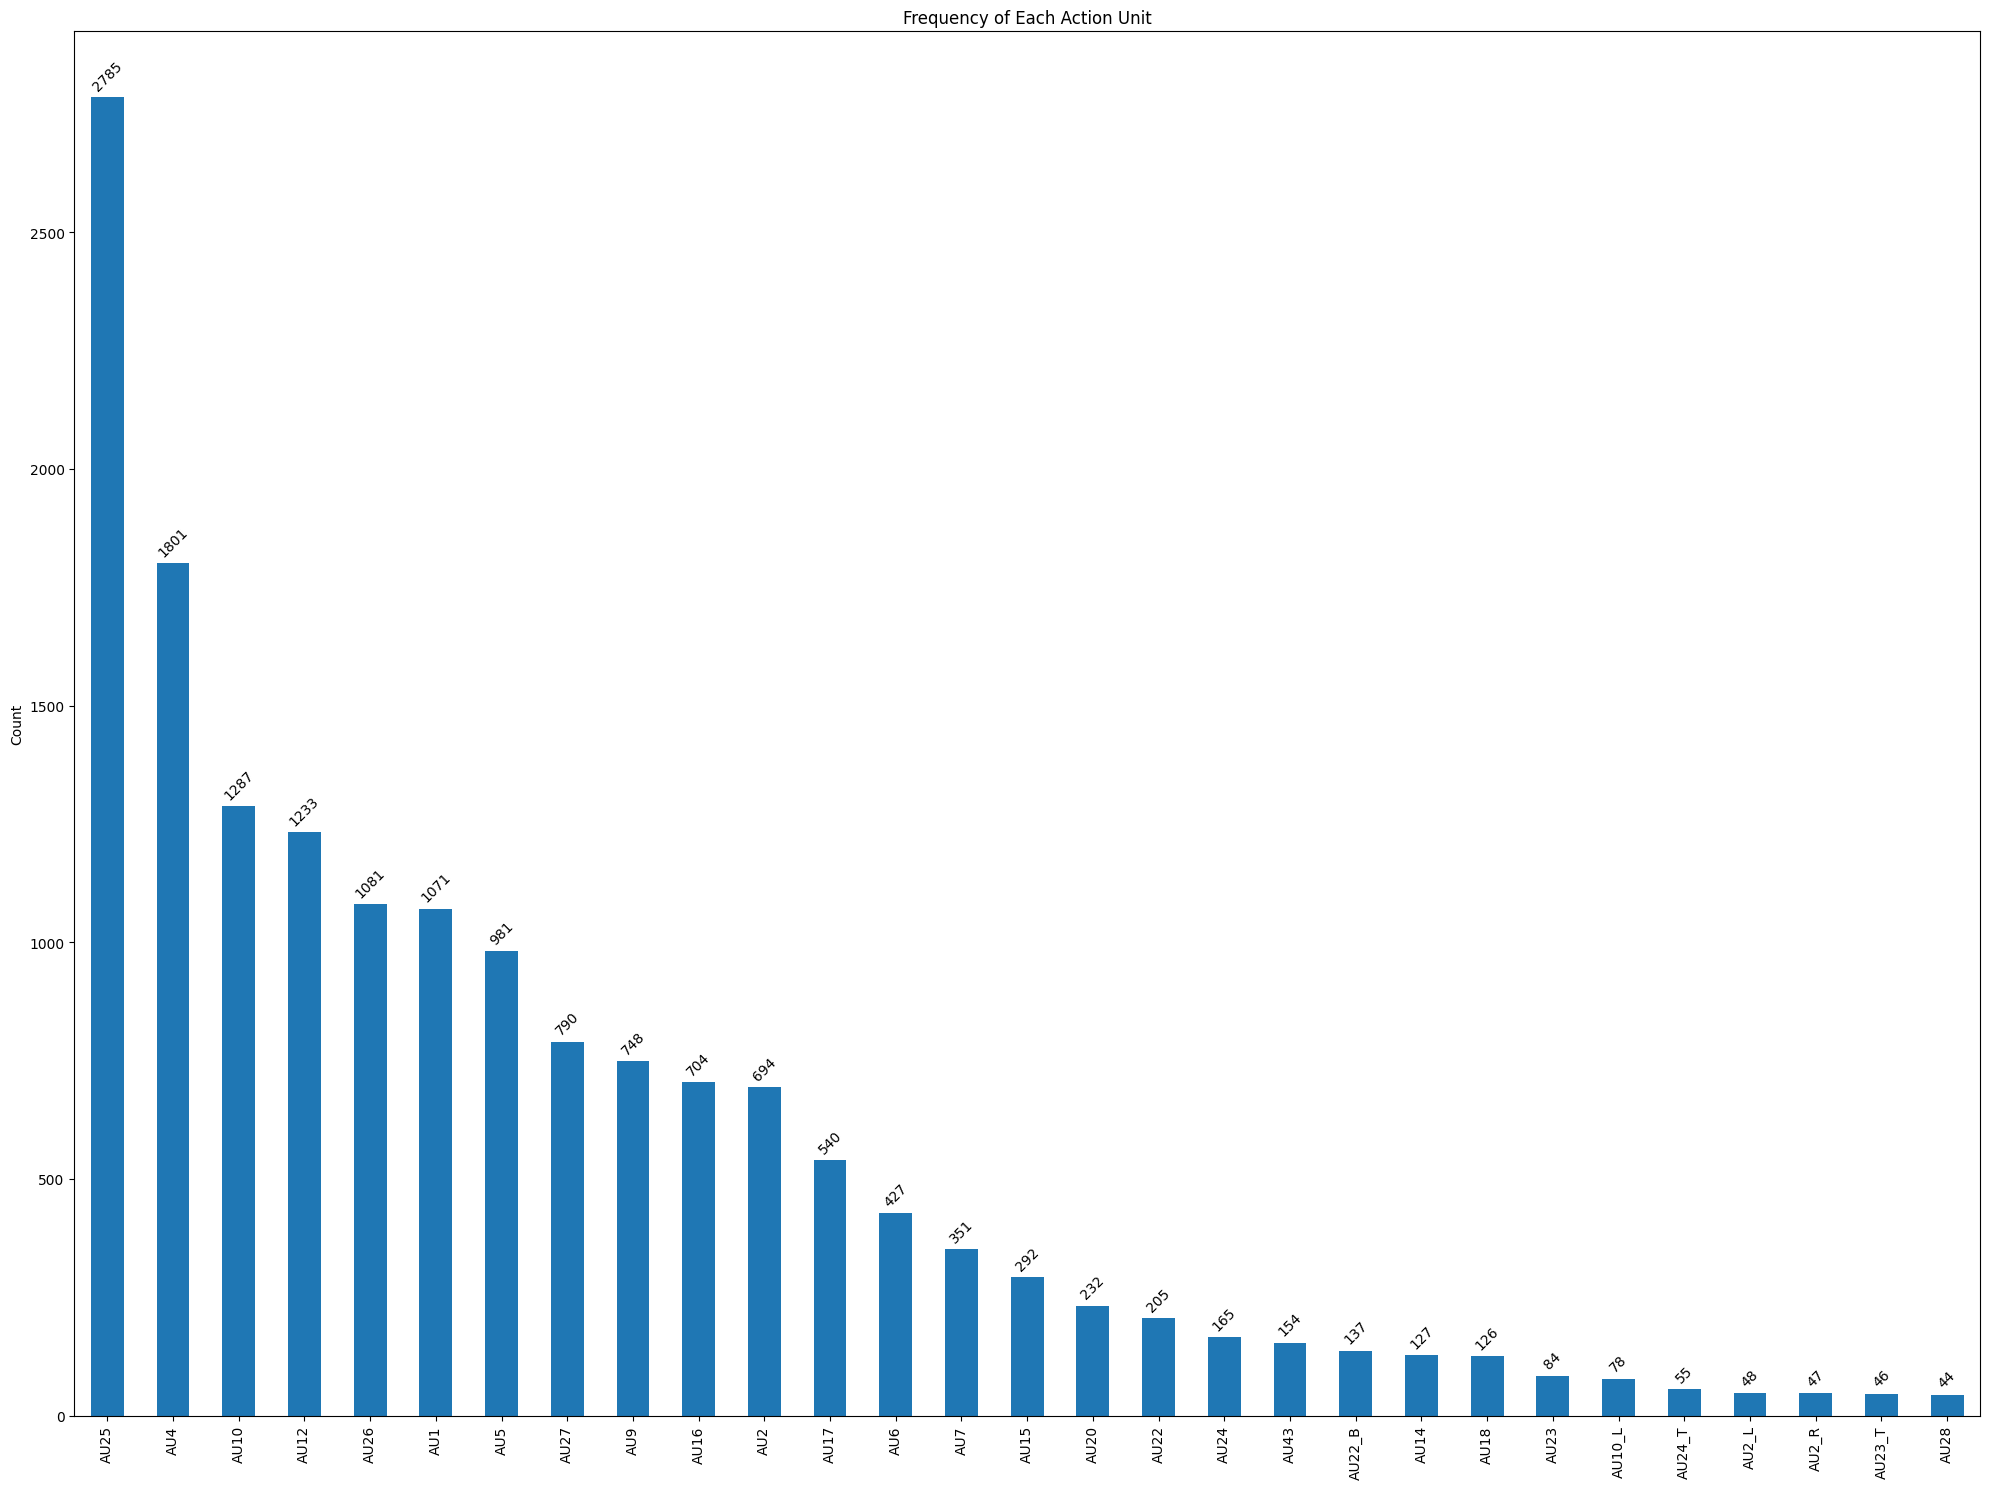

In [6]:
plt.figure(figsize=(20,15))
au_columns = [c for c in au_df.columns.drop("image")]
au_frequencies = au_df[au_columns].sum().sort_values(ascending=False)

ax = au_frequencies.plot(kind="bar")

ax.bar_label(ax.containers[0], padding=3, rotation=45)

plt.title("Frequency of Each Action Unit")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

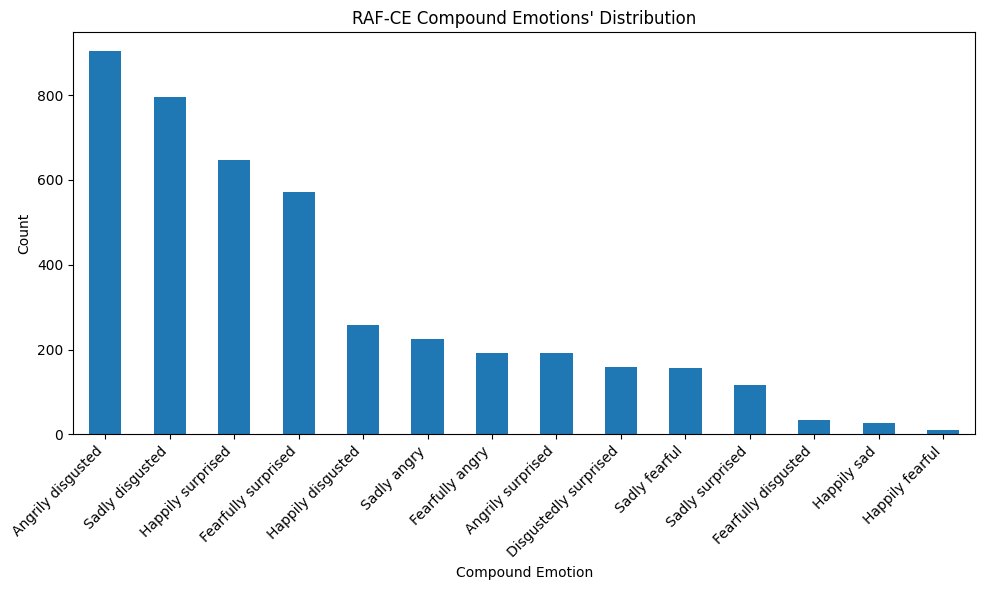

In [7]:

emotion_map = {
    0: 'Happily surprised',
    1: 'Happily disgusted',
    2: 'Sadly fearful',
    3: 'Sadly angry',
    4: 'Sadly surprised',
    5: 'Sadly disgusted',
    6: 'Fearfully angry',
    7: 'Fearfully surprised',
    8: 'Fearfully disgusted',
    9: 'Angrily surprised',
    10: 'Angrily disgusted',
    11: 'Disgustedly surprised',
    12: 'Happily fearful',
    13: 'Happily sad'
}
counts = compound_df["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
counts.plot(kind="bar", figsize=(10,6))
plt.title("RAF-CE Compound Emotions' Distribution")
plt.xlabel("Compound Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [8]:
print(counts)

compound_emotion
Angrily disgusted        903
Sadly disgusted          795
Happily surprised        646
Fearfully surprised      572
Happily disgusted        259
Sadly angry              225
Fearfully angry          192
Angrily surprised        192
Disgustedly surprised    160
Sadly fearful            156
Sadly surprised          117
Fearfully disgusted       35
Happily sad               28
Happily fearful           11
Name: count, dtype: int64


Huge class imbalance 

### Processing of the compound emotions 
this section will be dedicated to the processing of the compound emotions only.

In [10]:
compound_emotion_labels = pd.read_csv(
    "../../../../Documents/FER-CE-Vision-LLM/data/RAFCE_emolabel.txt",
    sep=r"\s+",
    header=None,
    names=["image","compound_emotion"]
)
compound_emotion_labels.head()

,image,compound_emotion
0,0001.jpg,5
1,0002.jpg,5
2,0003.jpg,10
3,0004.jpg,3
4,0005.jpg,10


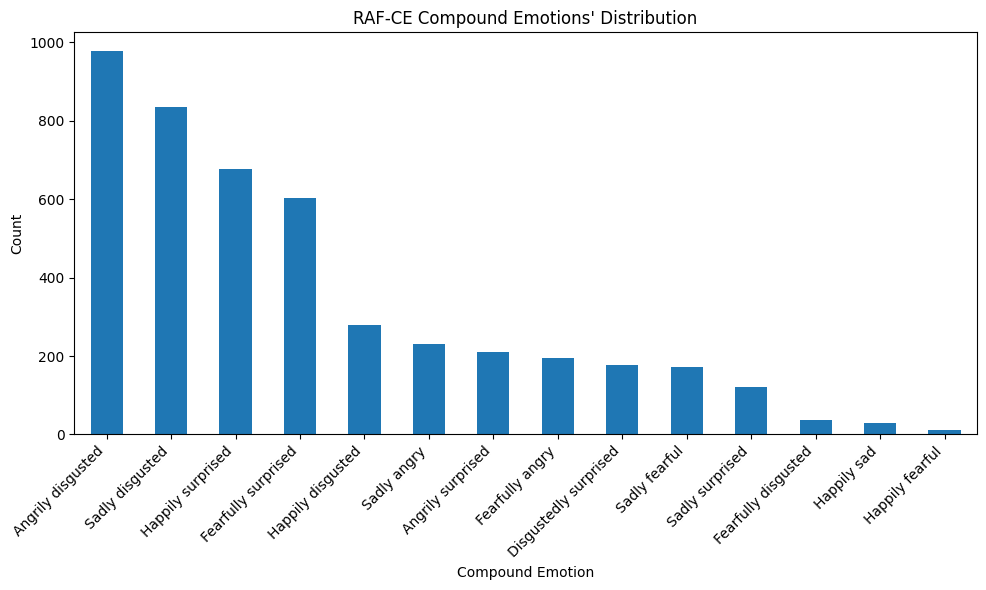

In [11]:

emotion_map = {
    0: 'Happily surprised',
    1: 'Happily disgusted',
    2: 'Sadly fearful',
    3: 'Sadly angry',
    4: 'Sadly surprised',
    5: 'Sadly disgusted',
    6: 'Fearfully angry',
    7: 'Fearfully surprised',
    8: 'Fearfully disgusted',
    9: 'Angrily surprised',
    10: 'Angrily disgusted',
    11: 'Disgustedly surprised',
    12: 'Happily fearful',
    13: 'Happily sad'
}
counts = compound_emotion_labels["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
counts.plot(kind="bar", figsize=(10,6))
plt.title("RAF-CE Compound Emotions' Distribution")
plt.xlabel("Compound Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45,ha="right")
plt.tight_layout()
plt.show()

In [12]:
print(counts)

compound_emotion
Angrily disgusted        977
Sadly disgusted          835
Happily surprised        676
Fearfully surprised      603
Happily disgusted        279
Sadly angry              230
Angrily surprised        210
Fearfully angry          195
Disgustedly surprised    177
Sadly fearful            171
Sadly surprised          120
Fearfully disgusted       36
Happily sad               29
Happily fearful           11
Name: count, dtype: int64


In [ ]:

import shutil
import os
split_file = "../../../../Documents/FER-CE-Vision-LLM/data/RAFCE_partition.txt"         
img_dir = "../../../../Documents/FER-CE-Vision-LLM/data/raw/aligned"            
train_dir = "../../../../Documents/FER-CE-Vision-LLM/data/train_images"        

os.makedirs(train_dir, exist_ok=True)

with open(split_file, "r") as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()
    if len(parts) != 2:
        continue  
    img_name, split_label = parts
    if split_label == "0": 
        src_path = os.path.join(img_dir, img_name)
        dst_path = os.path.join(train_dir, img_name)
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)



In [67]:
train_img_dir = "../../../../Documents/FER-CE-Vision-LLM/data/train_images" 
train_images = set(os.listdir(train_img_dir))

train_df = compound_df[compound_df['image'].isin(train_images)].copy()

print(f"Nombre d'images de train : {len(train_df)}")
print(train_df.head())

Nombre d'images de train : 2539
      image  compound_emotion
0  0001.jpg                 5
3  0004.jpg                 3
4  0005.jpg                10
5  0006.jpg                 3
6  0007.jpg                 2


In [68]:
counts = train_df["compound_emotion"].value_counts()
counts.index = counts.index.map(emotion_map)
print(counts)

compound_emotion
Angrily disgusted        530
Sadly disgusted          467
Happily surprised        376
Fearfully surprised      334
Happily disgusted        159
Sadly angry              133
Fearfully angry          117
Angrily surprised        113
Sadly fearful            101
Disgustedly surprised     94
Sadly surprised           70
Fearfully disgusted       23
Happily sad               16
Happily fearful            6
Name: count, dtype: int64


I. Data Augmentation & Normalization

In [69]:
from torchvision import transforms

ultra_rare_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

rare_augmentation = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

frequent_augmentation = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [70]:
from torch.utils.data import Dataset
from PIL import Image

class RAFCEDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir

        self.class_counts = df["compound_emotion"].value_counts()

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(img_path).convert("RGB")
        label = row["compound_emotion"]

        count = self.class_counts[label]
        if count < 30:
            transform = ultra_rare_augmentation
        elif count < 200:
            transform = rare_augmentation
        else :
            transform = frequent_augmentation

        if transform:
            image = transform(image)
        
        return image, label

In [75]:
train_dataset = RAFCEDataset(df=train_df, img_dir="../../../../Documents/FER-CE-Vision-LLM/data/train_images")

In [76]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [77]:
images, labels = next(iter(train_loader))
print(images.shape) 
print(labels[:10])

torch.Size([32, 3, 224, 224])
tensor([ 0,  2,  4,  0,  0, 13,  0,  0,  1,  9])


In [ ]:
#IMPORTS & DEVICE
import os
import shutil
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [ ]:
#ÉTAPE 1 : SPLIT TRAIN / TEST (RAFCE_partition.txt)
working_dir = "../../../../Documents/FER-CE-Vision-LLM/data/"
img_dir = working_dir + "raw/aligned"
split_file = working_dir + "RAFCE_partition.txt"

train_dir = working_dir + "train_images"
test_dir  = working_dir + "test_images"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with open(split_file) as f:
    for line in f:
        img, split = line.strip().split()
        src = os.path.join(img_dir, img)

        if not os.path.exists(src):
            continue

        if split == "0":
            shutil.copy(src, os.path.join(train_dir, img))
        elif split == "1":
            shutil.copy(src, os.path.join(test_dir, img))

print("Train images:", len(os.listdir(train_dir)))
print("Test images :", len(os.listdir(test_dir)))


Train images: 2709
Test images : 909


In [ ]:
#CHARGEMENT DES LABELS NETTOYÉS
compound_df = pd.read_csv(working_dir + "compound_df_clean.csv")
print("Total samples:", len(compound_df))
compound_df.head()


Total samples: 4291


,image,compound_emotion
0,0001.jpg,5
1,0002.jpg,5
2,0003.jpg,10
3,0004.jpg,3
4,0005.jpg,10


In [ ]:
#DATAFRAME TRAIN / TEST
rain_images = set(os.listdir(train_dir))
test_images  = set(os.listdir(test_dir))

train_df = compound_df[compound_df["image"].isin(train_images)].reset_index(drop=True)
test_df  = compound_df[compound_df["image"].isin(test_images)].reset_index(drop=True)

print("Train size:", len(train_df))
print("Test size :", len(test_df))


Train size: 2539
Test size : 862


In [ ]:
#DATASET PYTORCH
class RAFCEDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image"])
        image = Image.open(img_path).convert("RGB")
        label = row["compound_emotion"]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
#TRANSFORMS (TRAIN / TEST)
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
#DATALOADERS
train_dataset = RAFCEDataset(train_df, train_dir, train_transform)
test_dataset  = RAFCEDataset(test_df, test_dir, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))
print(images.shape, labels[:10])


torch.Size([32, 3, 224, 224]) tensor([10,  9,  0,  0, 11,  1, 10, 10,  5, 11])


In [ ]:
#MODÈLE EFFICIENTNET (Baseline Vision-Only)
from torchvision import models
import torch.nn as nn

model = models.efficientnet_b0(pretrained=True)

# Remplacer la tête de classification
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 14)

model = model.to(device)
model


c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\mayso/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:06<00:00, 3.43MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#LOSS & OPTIMIZER (adaptés à EfficientNet)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)


In [10]:
#BOUCLE D’ENTRAÎNEMENT
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10] - Loss: 2.0908
Epoch [2/10] - Loss: 1.6569
Epoch [3/10] - Loss: 1.3669
Epoch [4/10] - Loss: 1.0849
Epoch [5/10] - Loss: 0.8526
Epoch [6/10] - Loss: 0.6576
Epoch [7/10] - Loss: 0.4850
Epoch [8/10] - Loss: 0.3864
Epoch [9/10] - Loss: 0.2886
Epoch [10/10] - Loss: 0.2279


In [11]:
#ÉVALUATION (F1-MACRO)
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu()

        y_true.extend(labels)
        y_pred.extend(preds)

print(classification_report(y_true, y_pred, digits=4))
print("F1-macro:", f1_score(y_true, y_pred, average="macro"))


              precision    recall  f1-score   support

           0     0.5608    0.6917    0.6194       120
           1     0.2821    0.2200    0.2472        50
           2     0.2857    0.3125    0.2985        32
           3     0.1148    0.1628    0.1346        43
           4     0.4286    0.1304    0.2000        23
           5     0.5493    0.6763    0.6062       173
           6     0.8125    0.3023    0.4407        43
           7     0.5446    0.5288    0.5366       104
           8     0.0000    0.0000    0.0000         6
           9     0.3191    0.3571    0.3371        42
          10     0.5563    0.4641    0.5060       181
          11     0.1750    0.1944    0.1842        36
          12     0.0000    0.0000    0.0000         1
          13     0.0000    0.0000    0.0000         8

    accuracy                         0.4698       862
   macro avg     0.3306    0.2886    0.2936       862
weighted avg     0.4783    0.4698    0.4625       862

F1-macro: 0.2936079333239

c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

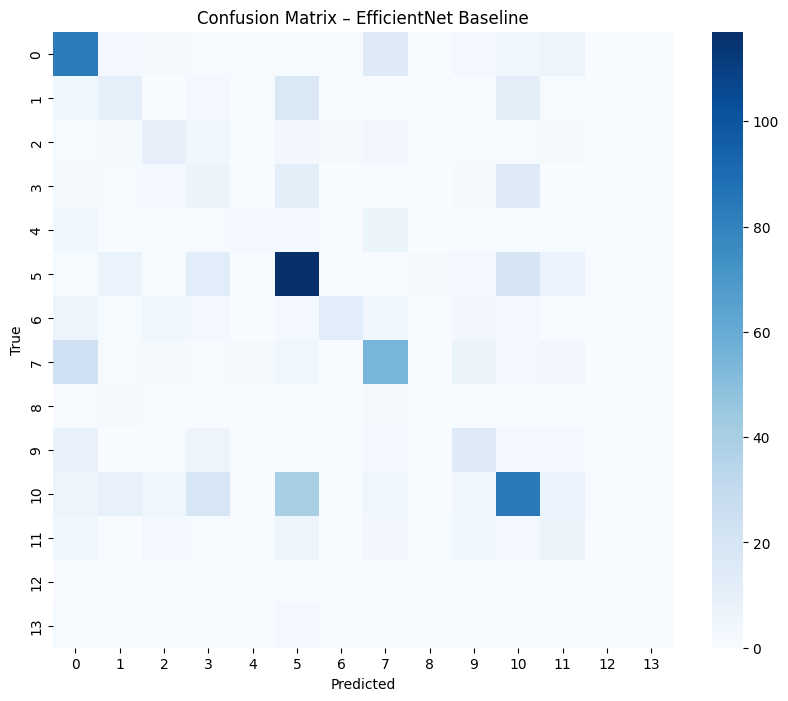

In [12]:
#CONFUSION MATRIX (EFFICIENTNET)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix – EfficientNet Baseline")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
#SAUVEGARDE DU MODÈLE
torch.save(model.state_dict(), "efficientnet_rafce_baseline.pth")
print("EfficientNet baseline saved.")


EfficientNet baseline saved.


In [14]:
#IMPORTS POUR GRAD-CAM
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image


In [15]:
#FONCTION GRAD-CAM
def grad_cam(model, image, target_class=None):
    """
    Inputs:
        model: votre modèle (EfficientNet)
        image: tensor (1,3,224,224)
        target_class: int, index de la classe à visualiser (si None -> classe prédite)
    Returns:
        heatmap: np.array 224x224
    """
    model.eval()

    # Récupérer la dernière couche convolutionnelle
    conv_layer = model.features[-1]  # EfficientNet B0, dernière couche conv
    activations = None
    gradients = None

    # Hook pour capturer les activations
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Hook pour capturer les gradients
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    handle_f = conv_layer.register_forward_hook(forward_hook)
    handle_b = conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image)
    if target_class is None:
        target_class = output.argmax(1).item()

    # Zero gradients
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Grad-CAM
    pooled_gradients = torch.mean(gradients, dim=[0,2,3])
    activations = activations.detach()[0]

    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    heatmap = torch.sum(activations, dim=0)
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.cpu().numpy()
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.resize(heatmap, (224,224))

    # Supprimer hooks
    handle_f.remove()
    handle_b.remove()

    return heatmap


In [16]:
#FONCTION D’AFFICHAGE GRAD-CAM
def show_grad_cam(image_tensor, heatmap):
    """
    Inputs:
        image_tensor: Tensor (1,3,224,224)
        heatmap: np.array 224x224
    """
    image = to_pil_image(image_tensor.squeeze().cpu())
    heatmap = np.uint8(plt.cm.jet(heatmap/255.0)[:, :, :3]*255)
    heatmap_img = Image.fromarray(heatmap).resize(image.size)
    
    # Superposition
    overlay = Image.blend(image, heatmap_img, alpha=0.5)
    
    # Affichage
    plt.figure(figsize=(6,6))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.title("Grad-CAM")
    plt.imshow(heatmap_img)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()



c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


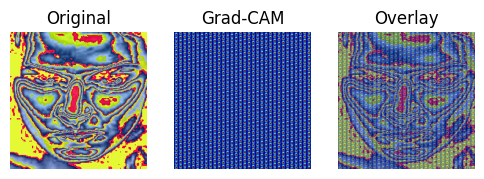

Classe vraie : 10
Classe prédite : 10


In [17]:
#EXEMPLE D’UTILISATION SUR UNE IMAGE
# Prendre la première image du test loader
image, label = next(iter(test_loader))
image = image[0].unsqueeze(0).to(device)  # ajouter batch dimension

# Calculer Grad-CAM
heatmap = grad_cam(model, image)

# Affichage
show_grad_cam(image, heatmap)

print("Classe vraie :", label[0].item())
pred_class = model(image).argmax(1).item()
print("Classe prédite :", pred_class)


In [18]:
#GRAD-CAM OPTIMISÉ POUR UN BATCH
def batch_grad_cam(model, images, target_classes=None):
    """
    Inputs:
        model: EfficientNet
        images: Tensor (B,3,224,224)
        target_classes: list ou None (classe à visualiser pour chaque image)
    Returns:
        heatmaps: list de np.array (224x224)
    """
    model.eval()
    heatmaps = []

    conv_layer = model.features[-1]
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    handle_f = conv_layer.register_forward_hook(forward_hook)
    handle_b = conv_layer.register_backward_hook(backward_hook)

    images = images.to(device)
    outputs = model(images)

    if target_classes is None:
        target_classes = outputs.argmax(1).tolist()
    
    for i, target_class in enumerate(target_classes):
        model.zero_grad()
        outputs[i, target_class].backward(retain_graph=True)

        pooled_gradients = torch.mean(gradients[i], dim=[0,2,3])
        act = activations[i].detach()
        for j in range(act.shape[0]):
            act[j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(act, dim=0)
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()
        heatmap = np.uint8(255 * heatmap)
        heatmap = np.resize(heatmap, (224,224))

        heatmaps.append(heatmap)

    handle_f.remove()
    handle_b.remove()
    return heatmaps


In [22]:
#AFFICHAGE EN TABLEAU MULTI-IMAGES
import torch.nn.functional as F

def batch_grad_cam(model, images, target_classes=None):
    """
    Inputs:
        model: EfficientNet
        images: Tensor (B,3,224,224)
        target_classes: list ou None (classe à visualiser pour chaque image)
    Returns:
        heatmaps: list de np.array (224x224)
    """
    model.eval()
    heatmaps = []

    conv_layer = model.features[-1]  # dernière couche convolutive
    activations = None
    gradients = None

    # Hook pour récupérer activations
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    # Hook pour récupérer gradients
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    handle_f = conv_layer.register_forward_hook(forward_hook)
    handle_b = conv_layer.register_backward_hook(backward_hook)

    images = images.to(device)
    outputs = model(images)

    if target_classes is None:
        target_classes = outputs.argmax(1).tolist()

    for i, target_class in enumerate(target_classes):
        model.zero_grad()
        outputs[i, target_class].backward(retain_graph=True)

        # Correction ici : gradients[i] est [C,H,W]
        pooled_gradients = torch.mean(gradients[i], dim=(1,2))  # moyenne sur H et W
        act = activations[i].detach()  # [C,H,W]
        for j in range(act.shape[0]):
            act[j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(act, dim=0)
        heatmap = F.relu(heatmap)
        heatmap /= heatmap.max() + 1e-6  # normalisation
        heatmap = heatmap.cpu().numpy()
        heatmap = np.uint8(255 * heatmap)
        heatmaps.append(heatmap)

    handle_f.remove()
    handle_b.remove()
    return heatmaps


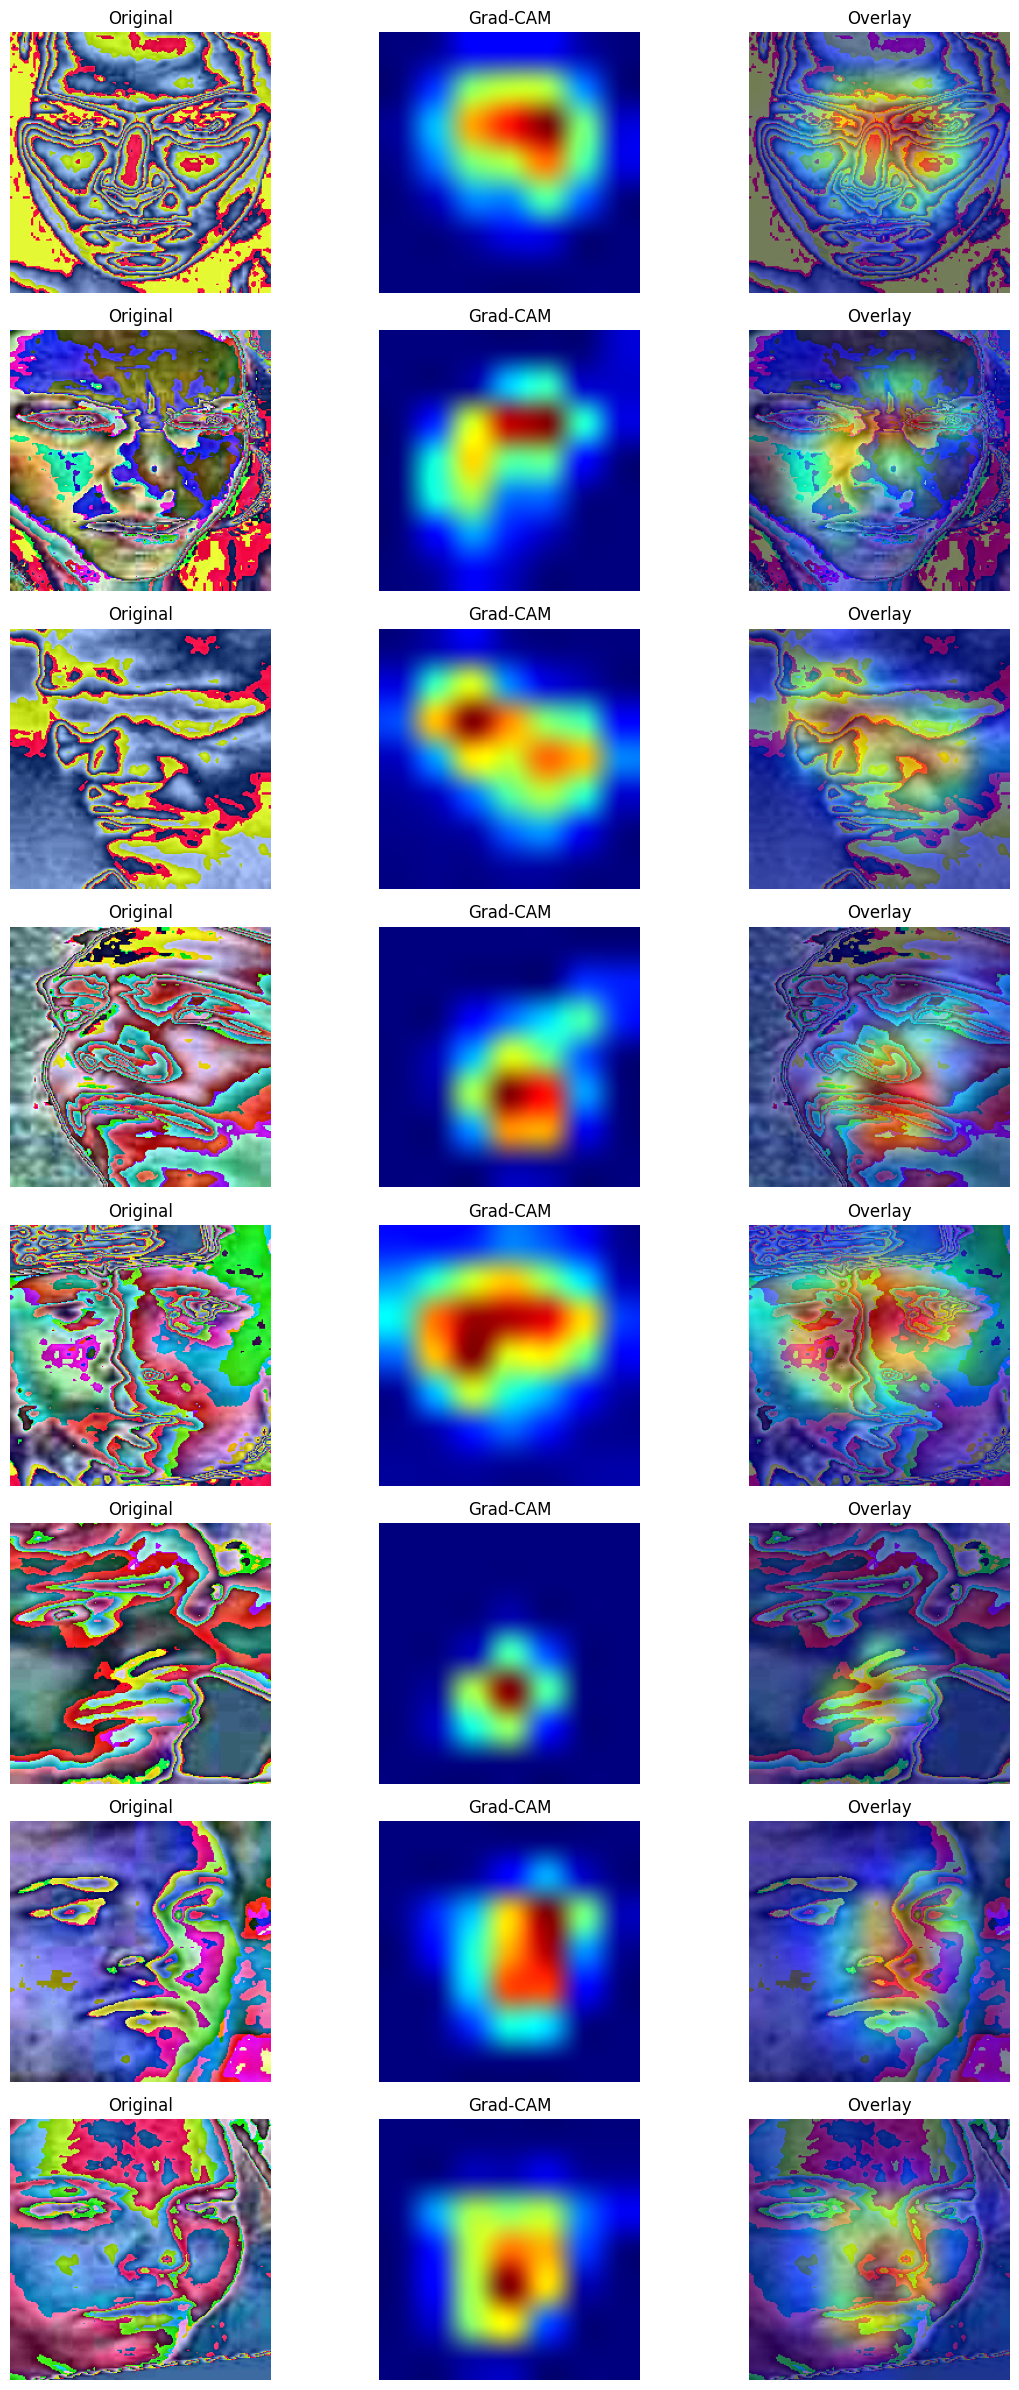

Image 1 | True: 10 | Pred: 10
Image 2 | True: 10 | Pred: 10
Image 3 | True: 5 | Pred: 3
Image 4 | True: 5 | Pred: 5
Image 5 | True: 9 | Pred: 9
Image 6 | True: 2 | Pred: 5
Image 7 | True: 5 | Pred: 10
Image 8 | True: 5 | Pred: 5


In [23]:
#EXEMPLE SUR UN BATCH DE TEST
images, labels = next(iter(test_loader))
images_batch = images[:8]
labels_batch = labels[:8].tolist()

# Calcul Grad-CAM batch
heatmaps_batch = batch_grad_cam(model, images_batch)

# Affichage
show_batch_grad_cam(images_batch, heatmaps_batch, n=8)

# Affichage des classes vraies et prédites
preds_batch = model(images_batch.to(device)).argmax(1).cpu().tolist()
for i in range(len(images_batch)):
    print(f"Image {i+1} | True: {labels_batch[i]} | Pred: {preds_batch[i]}")


In [19]:
!pip uninstall torch torchvision torchaudio -y


Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Found existing installation: torchvision 0.24.1
Uninstalling torchvision-0.24.1:
  Successfully uninstalled torchvision-0.24.1
Found existing installation: torchaudio 2.9.1
Uninstalling torchaudio-2.9.1:
  Successfully uninstalled torchaudio-2.9.1


You can safely remove it manually.
You can safely remove it manually.


In [10]:
!pip install -q transformers accelerate sentencepiece


In [3]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Solution : utiliser un modèle BLIP2 différent
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", 
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

c:\Users\mayso\Downloads\Vision-LLM-FER-CE-dev\Vision-LLM-FER-CE-dev\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mayso\.cache\huggingface\hub\models--Salesforce--blip2-opt-2.7b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint

In [13]:
import torch
import torchvision.transforms as transforms

# Préprocessing typique EfficientNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_emotion_efficientnet(image):
    efficientnet_model.eval()

    img_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = efficientnet_model(img_tensor)
        probs = torch.softmax(logits, dim=1)

    confidence, pred_idx = torch.max(probs, dim=1)

    emotion = emotion_labels[pred_idx.item()]

    return emotion, confidence.item()


In [16]:
import torch

state_dict = torch.load("efficientnet_rafce_baseline.pth", map_location="cpu")
print(type(state_dict))
print(len(state_dict))
print(list(state_dict.keys())[:5])


<class 'collections.OrderedDict'>
360
['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var']


C:\Users\mayso\AppData\Local\Temp\ipykernel_18576\1281581670.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("efficientnet_rafce_baseline.pth", m

In [29]:
from torchvision import models
import torch.nn as nn
import torch

device = "cpu"  # forcer CPU

efficientnet_model = models.efficientnet_b0(pretrained=False)
in_features = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(in_features, 14)

efficientnet_model.load_state_dict(
    torch.load("efficientnet_rafce_baseline.pth", map_location="cpu")
)

efficientnet_model.to(device)
efficientnet_model.eval()


C:\Users\mayso\AppData\Local\Temp\ipykernel_18576\789104002.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("efficientnet_rafce_baseline.pth", map_location="

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [35]:
emotion_labels = [
    'Happily surprised',
    'Happily disgusted',
    'Sadly fearful',
    'Sadly angry',
    'Sadly surprised',
    'Sadly disgusted',
    'Fearfully angry',
    'Fearfully surprised',
    'Fearfully disgusted',
    'Angrily surprised',
    'Angrily disgusted',
    'Disgustedly surprised',
    'Happily fearful',
    'Happily sad'
]


In [36]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# 1) Préprocessing (même que pendant l'entraînement)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_emotion_efficientnet(image):
    efficientnet_model.eval()
    img_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = efficientnet_model(img_tensor)
        probs = torch.softmax(logits, dim=1)

    confidence, pred_idx = torch.max(probs, dim=1)
    emotion = emotion_labels[pred_idx.item()]

    return emotion, confidence.item()



In [37]:
image_path = "../../../../Downloads/Vision-LLM-FER-CE-dev/Vision-LLM-FER-CE-dev/data/train_images/0001.jpg"
image = Image.open(image_path).convert("RGB")

emotion, confidence = predict_emotion_efficientnet(image)
print("Emotion:", emotion)
print("Confidence:", confidence)


Emotion: Sadly disgusted
Confidence: 0.9989763498306274


In [40]:
prompt = (
    "What is the emotion of the person in the image?"

)

inputs = processor(
    images=image,
    text=prompt,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    ids = model.generate(
        **inputs,
        max_new_tokens=20,
        do_sample=False,   # plus stable
        num_beams=3,       # meilleure qualité
        early_stopping=True
    )

answer = processor.decode(ids[0], skip_special_tokens=True)
print("Answer:", answer)



Answer: What is the emotion of the person in the image?



ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434